In [1]:
from ta.momentum import PercentagePriceOscillator,RSIIndicator,ROCIndicator,WilliamsRIndicator,StochRSIIndicator
from ta.trend import MACD,ADXIndicator,CCIIndicator,sma_indicator,ema_indicator,PSARIndicator
from ta.volatility import BollingerBands,AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator,ChaikinMoneyFlowIndicator,MFIIndicator
import warnings
warnings.simplefilter('ignore')
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd
from binance import Client
api_key="LmId7IJ05Pft6aR9JtGhmlauJ9DfTHtH9BhWIdbYPkCBowbwejnLCExCR93gqhTT"
secret_key="MUuJx69AafPeVGbO5yuCEhSULacvxJm0lWlrVZJAa6Il1ZcIkgznt9Ru7JtifUPb"
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_binance_data(api_key, pair, countdown='open', interval='4h', start='6 December 2019', end='6 December 2022'):
  client = Client(api_key=api_key)
  intervals = {
      '1h':  Client.KLINE_INTERVAL_1HOUR
  }
  interval = intervals.get(interval, '1h')
  print(f'Historical interval {interval}')
  klines = client.get_historical_klines(symbol=pair, interval=interval, start_str=start, end_str=end)
  data = pd.DataFrame(klines)
  data.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
  data.index = [pd.to_datetime(x, unit='ms').strftime('%Y-%m-%d %H:%M:%S') for x in data.open_time]
  usecols=['open', 'high', 'low', 'close', 'volume']
  data = data[usecols]
  data = data.astype('float')
  return data

In [3]:
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [4]:
#ppo
def get_features(btc,fill=False):
    indicator_ppo = PercentagePriceOscillator(close=btc["close"],fillna=fill)
    indicator_rsi= RSIIndicator(close=btc['close'],fillna=fill)
    indicator_adx= ADXIndicator(high=btc['high'],low=btc['low'],close=btc['close'],fillna=fill)
    indicator_cci=CCIIndicator(high=btc['high'],low=btc['low'],close=btc['close'],fillna=fill)
    indicator_roc = ROCIndicator(close=btc['close'],fillna=fill)
    indicator_macd=MACD(close=btc['close'],fillna=fill)
    indicator_william_r = WilliamsRIndicator(high=btc['high'],low=btc['low'],close=btc['close'],fillna=fill)
    indicator_bollinger= BollingerBands(close=btc['close'],fillna=fill)
    indicator_psa_r = PSARIndicator(high=btc['high'],low=btc['low'],close=btc['close'],fillna=fill)
    indicator_obv=OnBalanceVolumeIndicator(close=btc['close'],volume=btc['volume'],fillna=fill)
    indicator_chaikin=ChaikinMoneyFlowIndicator(high=btc['high'],low=btc['low'],close=btc['close'],volume=btc['volume'],fillna=fill)
    indicator_mfi= MFIIndicator(high=btc['high'],low=btc['low'],close=btc['close'],volume=btc['volume'],fillna=fill)
    indicator_ATR = AverageTrueRange(high=btc['high'],low=btc['low'],close=btc['close'],fillna=fill)
    indicator_stoch=StochRSIIndicator(close=btc['close'],fillna=fill)
    btc['rsi']=indicator_rsi.rsi()

    btc['ppo']=indicator_ppo.ppo()
    btc['macd']=indicator_macd.macd()
    btc['macd_signal']=indicator_macd.macd_signal()
    btc['macd_histogram']=indicator_macd.macd_diff()

    btc['adx']=indicator_adx.adx()
    btc['cci']=indicator_cci.cci()
    btc['roc']=indicator_roc.roc()
    btc['william_r']=indicator_william_r.williams_r()
    btc['sma20']=sma_indicator(close=btc['close'],window=20,fillna=fill)
    btc['sma50']=sma_indicator(close=btc['close'],window=50,fillna=fill)
    btc['sma100']=sma_indicator(close=btc['close'],window=100,fillna=fill)
    btc['ema20']=ema_indicator(close=btc['close'],window=20,fillna=fill)
    btc['ema50']=ema_indicator(close=btc['close'],window=50,fillna=fill)
    btc['ema100']=ema_indicator(close=btc['close'],window=100,fillna=fill)
    btc['bollinger_high']=indicator_bollinger.bollinger_hband()
    btc['bollinger_low']=indicator_bollinger.bollinger_lband()
    btc['bollinger_pband']=indicator_bollinger.bollinger_pband()
    btc['psa_r']=indicator_psa_r.psar()
    btc['obv']=indicator_obv.on_balance_volume()
    btc['cmf']=indicator_chaikin.chaikin_money_flow()
    btc['mfi']=indicator_mfi.money_flow_index()
    btc['atr']=indicator_ATR.average_true_range()
    btc[r'%d']=indicator_stoch.stochrsi_d()
    btc[r'%k']=indicator_stoch.stochrsi_k()
    btc['momentum']=btc['close'].rolling(90).apply(momentum,raw=False)
    return btc

In [5]:
btc=get_binance_data(api_key=api_key,pair="BTCBUSD")
btc=get_features(btc=btc)
eth=get_binance_data(api_key=api_key,pair="ETHBUSD")
eth=get_features(btc=eth)
bnb=get_binance_data(api_key=api_key,pair="BNBBUSD")
bnb=get_features(btc=bnb)

Historical interval 1h
Historical interval 1h
Historical interval 1h


### Further Analysis on Closing Price
As the model in the next milestone will focus on predicting closing price and this is the most significant variable so we need to analyze closing price for all pairs.

In [6]:
df=pd.DataFrame({'BTC':btc.close,
                'ETH':eth.close,
                'BNB':bnb.close})

In [7]:
df.head()

,BTC,ETH,BNB
2019-12-06 00:00:00,7375.45,147.40,15.7113
2019-12-06 01:00:00,7404.15,147.89,15.5973
2019-12-06 02:00:00,7398.00,147.75,15.5256
2019-12-06 03:00:00,7374.86,147.34,15.5563
2019-12-06 04:00:00,7401.29,147.53,15.5252


In [8]:
df.describe()

,BTC,ETH,BNB
count,26274.000000,26274.000000,26274.000000
mean,28645.904528,1662.451981,235.340757
std,17331.913216,1292.289051,192.789485
min,4115.940000,96.970000,7.682400
25%,11110.890000,373.710000,24.107300
50%,23680.005000,1541.490000,272.800000
75%,43009.075000,2696.585000,384.700000
max,68629.490000,4847.560000,684.900000


Text(0.5, 1.0, 'Boxplot for closing price: BTC')

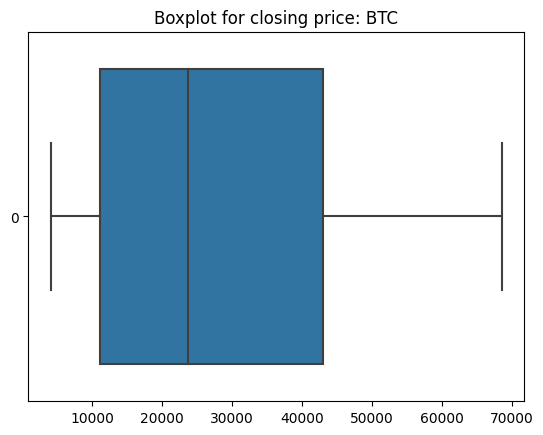

In [9]:
sns.boxplot(df['BTC'],orient="h")
plt.title("Boxplot for closing price: BTC")

Text(0.5, 1.0, 'Boxplot for closing price: ETH')

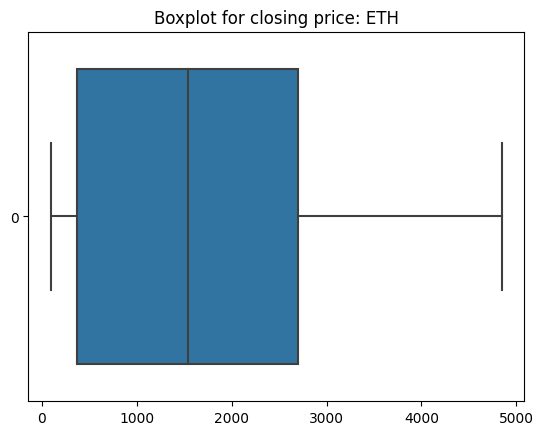

In [10]:
sns.boxplot(df['ETH'],orient="h")
plt.title("Boxplot for closing price: ETH")

Text(0.5, 1.0, 'Boxplot for closing price: BNB')

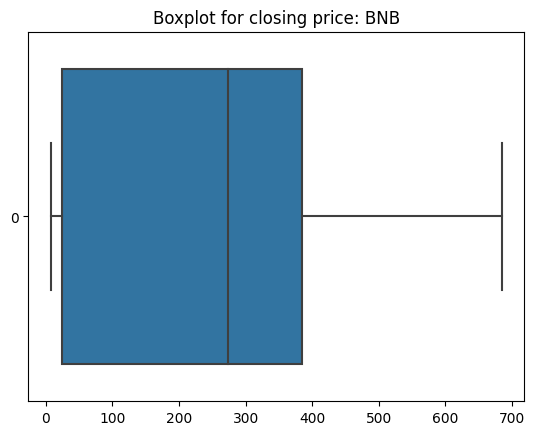

In [11]:
sns.boxplot(df['BNB'],orient="h")
plt.title("Boxplot for closing price: BNB")

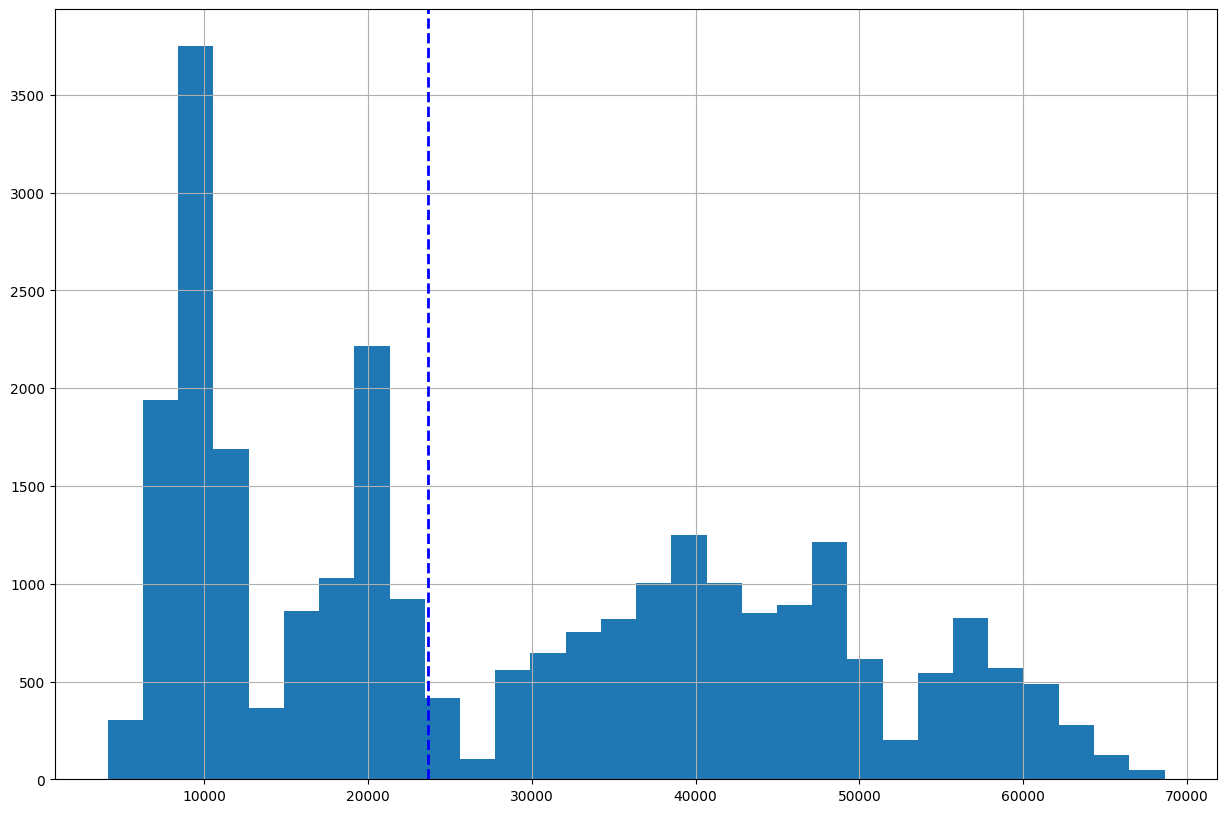

In [12]:
df['BTC'].hist(bins=30, figsize=(15,10)).axvline(df['BTC'].median(), color='b', linestyle='dashed', linewidth=2)

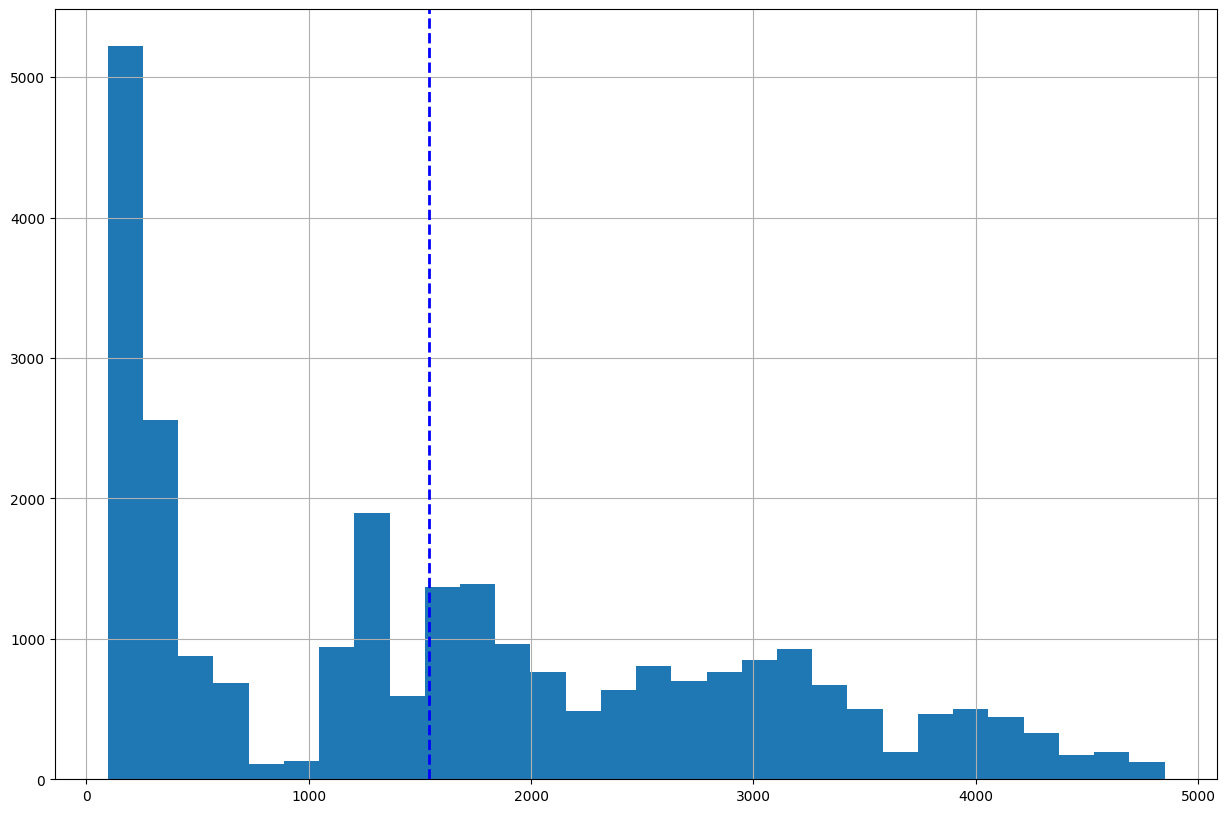

In [13]:
df['ETH'].hist(bins=30, figsize=(15,10)).axvline(df['ETH'].median(), color='b', linestyle='dashed', linewidth=2)

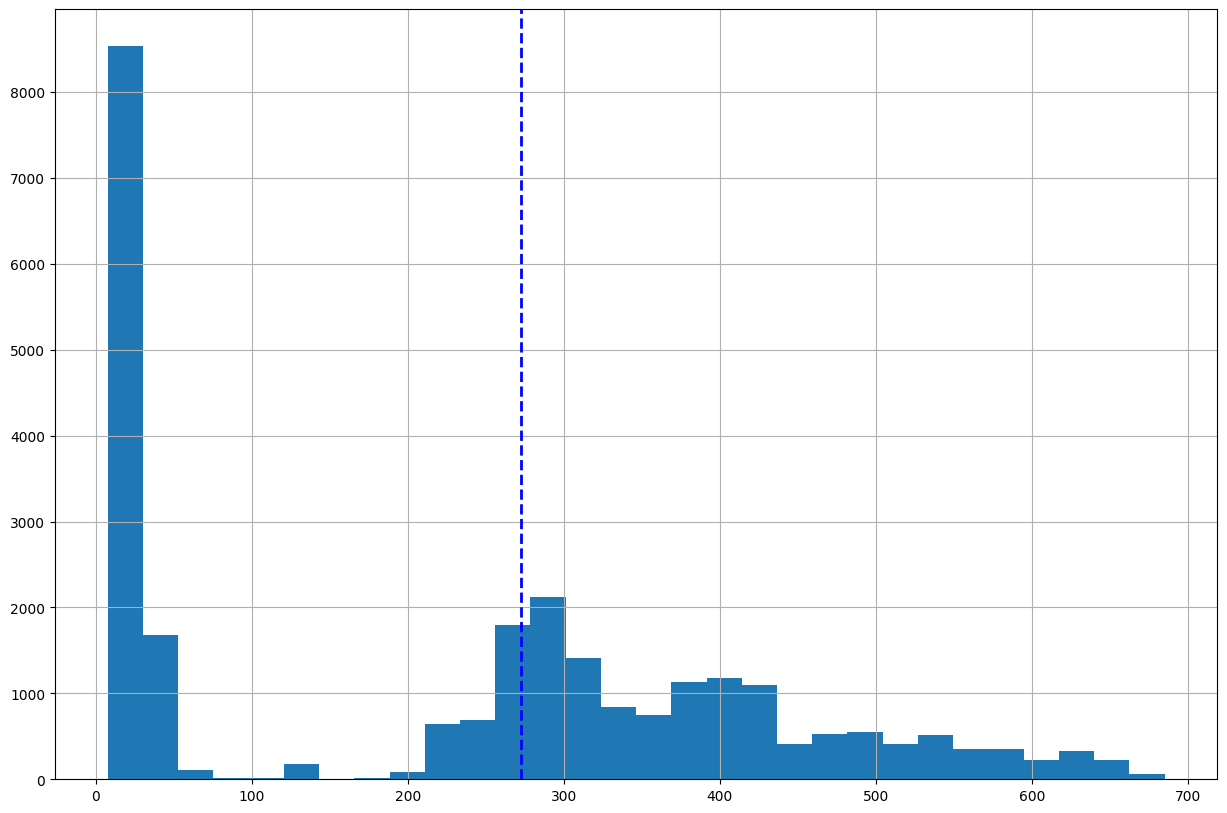

In [14]:
df['BNB'].hist(bins=30, figsize=(15,10)).axvline(df['BNB'].median(), color='b', linestyle='dashed', linewidth=2)

<AxesSubplot:>

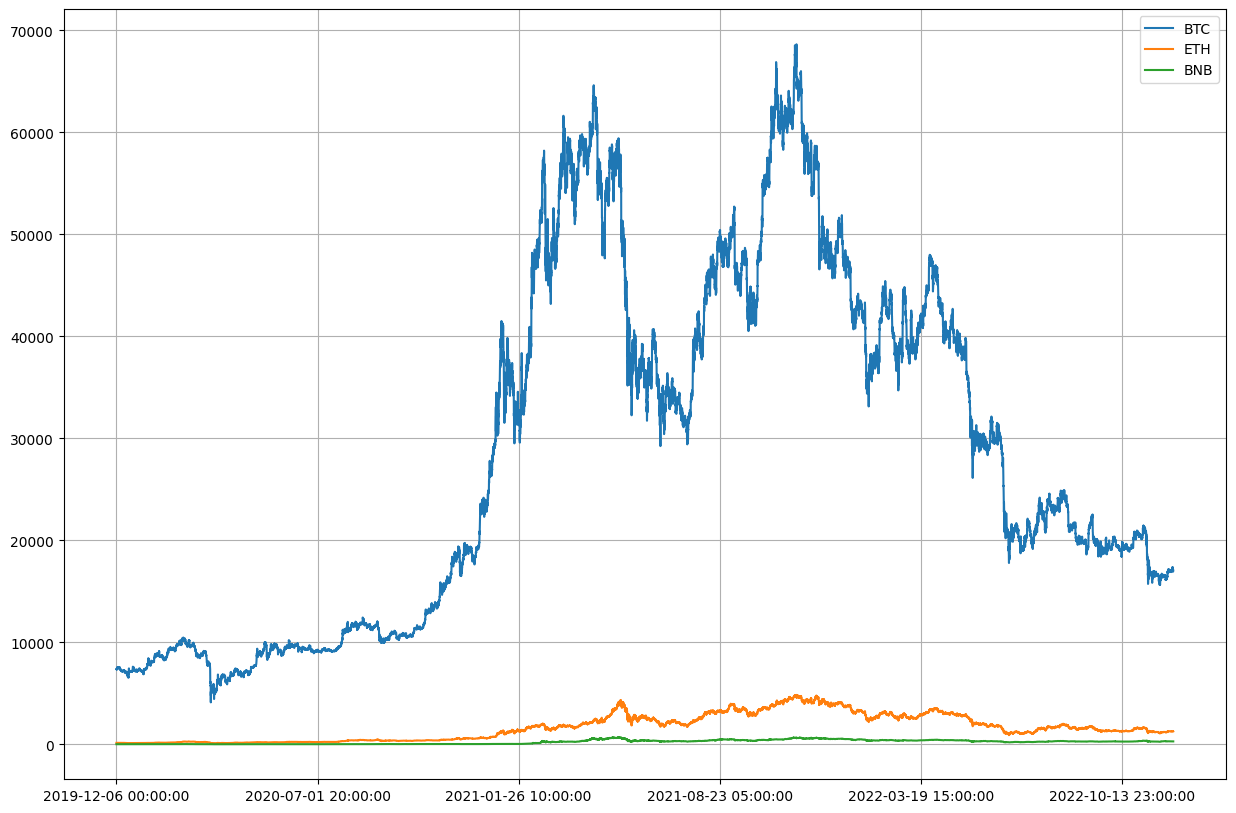

In [15]:
# close price
df.plot(grid=True, figsize=(15, 10))

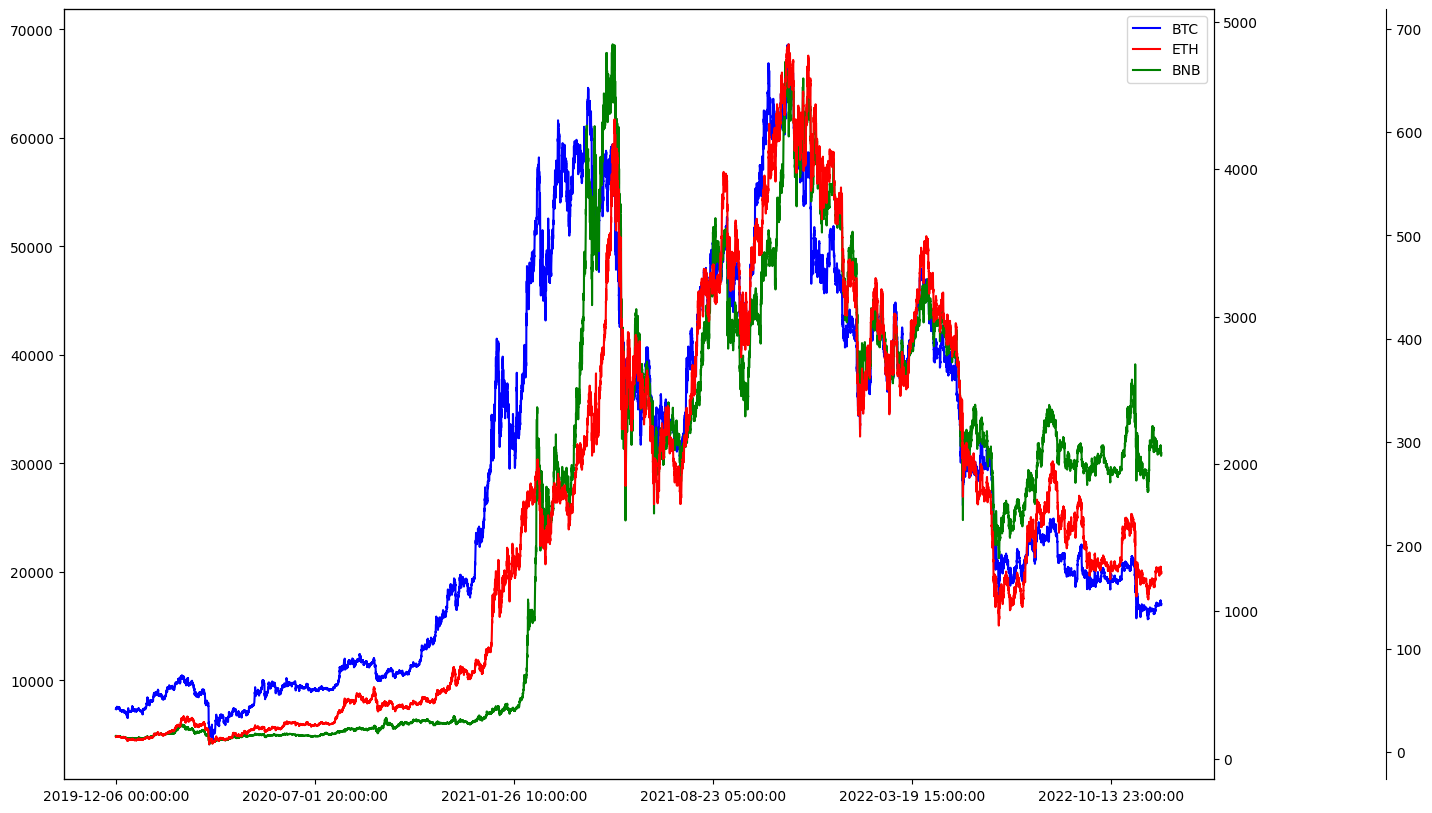

In [16]:
#relative change in closing price

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)
df['BTC'].plot(ax=ax1, style='b-')
df['ETH'].plot(ax=ax1, style='r-', secondary_y=True)
df['BNB'].plot(ax=ax2, style='g-')
# legend
ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
           ['BTC', 'ETH', 'BNB'])

<AxesSubplot:>

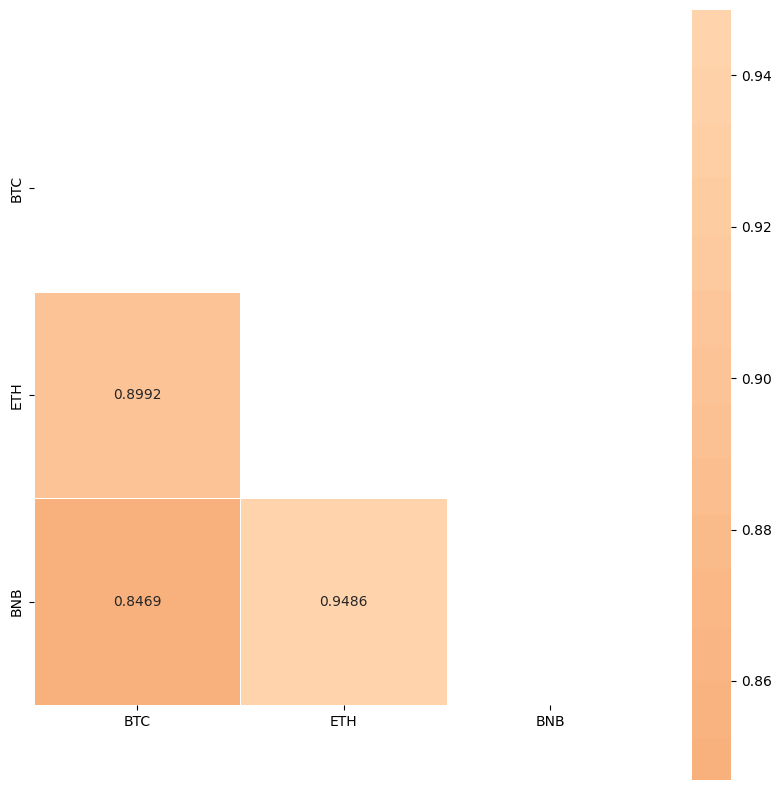

In [17]:
# correlation b/w prices
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

In [18]:
#buy and hold strategy
df_return = df.apply(lambda x: x / x[0])
df_return.head()

,BTC,ETH,BNB
2019-12-06 00:00:00,1.000000,1.000000,1.000000
2019-12-06 01:00:00,1.003891,1.003324,0.992744
2019-12-06 02:00:00,1.003057,1.002374,0.988180
2019-12-06 03:00:00,0.999920,0.999593,0.990134
2019-12-06 04:00:00,1.003504,1.000882,0.988155


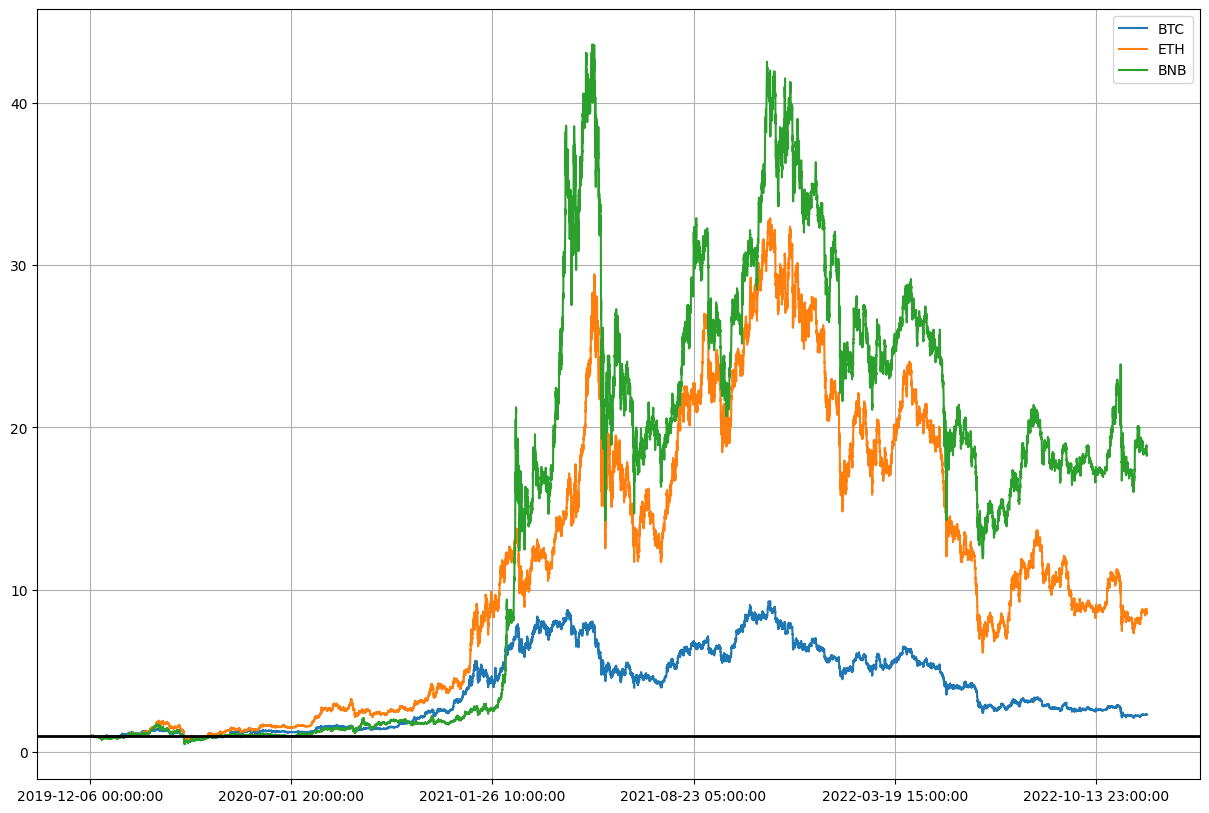

In [19]:
df_return.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

### What is percentage increase?

,BTC,ETH,BNB
2022-12-06 00:00:00,231.098035,859.31479,1841.986341


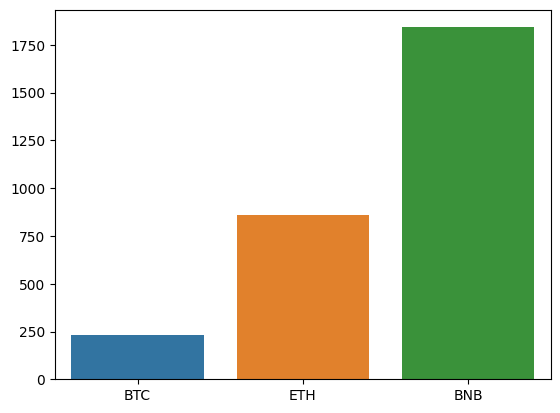

In [20]:
df_perc = df_return.tail(1) * 100
ax = sns.barplot(data=df_perc)
df_perc

### How many coins we can buy for $1000?

,BTC,ETH,BNB
2019-12-06 00:00:00,0.135585,6.784261,63.648457


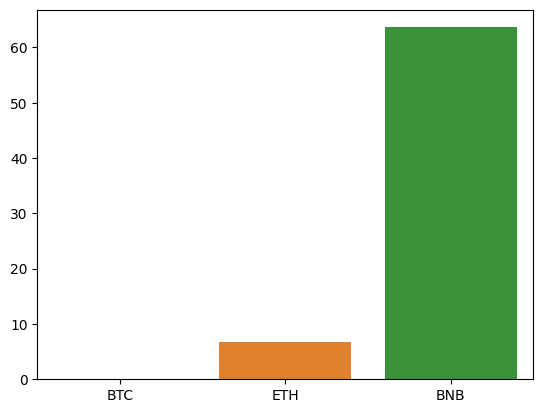

In [21]:
budget = 1000 # USD
df_coins = budget/df.head(1)

ax = sns.barplot(data=df_coins)
df_coins

### How much money would we make?

,BTC,ETH,BNB
2022-12-06 00:00:00,2310.980347,8593.147897,18419.86341


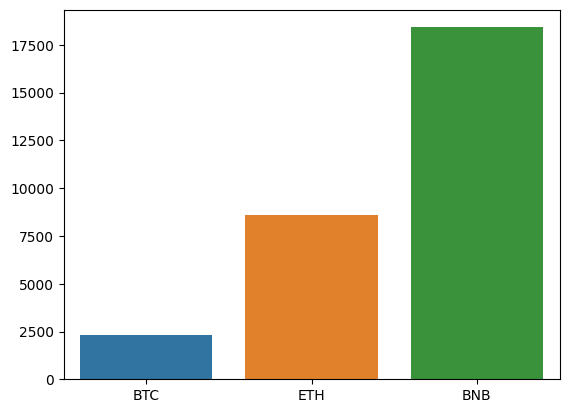

In [22]:
df_profit = df_return.tail(1) * budget

ax = sns.barplot(data=df_profit)
df_profit

In [23]:
df['year']=[x.split("-")[0] for x in df.index]
df.groupby('year').agg({'BTC':["mean","max"],
"ETH":["mean","max"],"BNB":["mean","max"]})

BTC                    ETH                  BNB          
              mean       max         mean      max        mean       max
year                                                                    
2019   7224.361090   7610.96   135.271683   151.24   14.039723   15.7693
2020  11069.154588  29160.98   306.066088   753.25   21.287946   39.4420
2021  47378.753119  68629.49  2771.970752  4847.56  377.708006  684.9000
2022  29086.927812  47990.00  2048.107450  3875.86  329.870984  531.5000